In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Convolution1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from datetime import datetime
import seaborn as sns
from pylab import rcParams
from keras.layers import Dropout
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 14, 10
from tensorflow import keras
eval_list = []

In [3]:
needfile = '/emogen/all'
def call_filelist(needfile):
    path = os.getcwd()
    files = os.listdir(path + needfile)
    if '.ipynb_checkpoints' in files:
        files.remove('.ipynb_checkpoints')
    return files

# 데이터 프레임 불러오기
def call_file(files, num, needfile):
    path = os.getcwd()
    df = pd.read_csv(path + needfile+ '/' + files[num], index_col = 0)
    df.set_index('Current Time',inplace = True)
    return df



In [4]:
files = call_filelist(needfile)
df = call_file(files, 0, needfile)


X = df.iloc[:, :-7].values
y = df.iloc[:, -7:].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


history_loss = []
history_accuracy = []
history_val_loss = []
history_val_accuracy = []
print(X_train.shape)


(4628, 8)


In [5]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
print(X_train.shape)

(4628, 8, 1)


In [6]:
"""
model = Sequential()
model.add(Convolution1D(128, 3, activation='relu', input_shape = (X_train.shape[0], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dense(64, activation='softmax'))
model.add(LSTM(64, input_shape = (X_train.shape[0], X_train.shape[2]), recurrent_dropout=0.5))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='softmax'))
"""
from keras.optimizers import RMSprop

opt = RMSprop(learning_rate=0.0001)

model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True, activation='softmax'))
model.add(Dropout(0.2))
model.add(LSTM(y_train.shape[1], activation='softmax'))

In [7]:
model.compile(loss=categorical_crossentropy , optimizer=opt, metrics=['accuracy'])

In [8]:
for num in range(len(files)):
    df = call_file(files, num, needfile)
    print(files[num])
    # 입력 데이터와 라벨 데이터를 분리
    X = df.iloc[:, :-7].values
    y = df.iloc[:, -7:].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
    # 입력 데이터를 3D 텐서로 변환
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


    print(X_train.shape)
    earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights = True)
    # 모델 학습 및 체크포인트 저장
    fit_history = model.fit(X_train, y_train, epochs=100, batch_size=3, validation_data=(X_val, y_val), callbacks=[earlystop])
    history_loss.extend(fit_history.history['loss'])
    history_accuracy.extend(fit_history.history['accuracy'])
    history_val_loss.extend(fit_history.history['val_loss'])
    history_val_accuracy.extend(fit_history.history['val_accuracy'])

    # 모델 평가
    loss, accuracy = model.evaluate(X_test, y_test)
    eval_list.append(accuracy)
    print('Test accuracy:', accuracy)
    print(num)
    #모델 저장
    model.save("my_model.h5")
    reconstructed_model = keras.models.load_model("my_model.h5")
    np.testing.assert_allclose(model.predict(X_test), 
                               reconstructed_model.predict(X_test)
                              )
    model = reconstructed_model
    model.compile(loss=categorical_crossentropy , optimizer='rmsprop', metrics=['accuracy'])


User002M_new_emo_gender.csv
(4165, 8, 1)
Epoch 1/100
1389/1389 [==============================] - 6s 3ms/step - loss: 1.7983 - accuracy: 0.8178 - val_loss: 1.6463 - val_accuracy: 0.8714
Epoch 2/100
1389/1389 [==============================] - 3s 2ms/step - loss: 1.4849 - accuracy: 0.8768 - val_loss: 1.3270 - val_accuracy: 0.8714
Epoch 3/100
1389/1389 [==============================] - 3s 2ms/step - loss: 1.1637 - accuracy: 0.8768 - val_loss: 1.0165 - val_accuracy: 0.8714
Epoch 4/100
1389/1389 [==============================] - 3s 2ms/step - loss: 0.8784 - accuracy: 0.8768 - val_loss: 0.7702 - val_accuracy: 0.8714
Epoch 5/100
1389/1389 [==============================] - 3s 2ms/step - loss: 0.6770 - accuracy: 0.8768 - val_loss: 0.6218 - val_accuracy: 0.8714
Epoch 6/100
1389/1389 [==============================] - 3s 2ms/step - loss: 0.5690 - accuracy: 0.8768 - val_loss: 0.5506 - val_accuracy: 0.8714
Epoch 7/100
1389/1389 [==============================] - 3s 2ms/step - loss: 0.5175 - acc

1270/1270 [==============================] - 2s 2ms/step - loss: 0.2556 - accuracy: 0.9451 - val_loss: 0.2622 - val_accuracy: 0.9454
Epoch 16: early stopping
17/17 [==============================] - 0s 1ms/step - loss: 0.2516 - accuracy: 0.9472
Test accuracy: 0.947169840335846
2
17/17 [==============================] - 0s 1ms/step
User005M_new_emo_gender.csv
(4671, 8, 1)
Epoch 1/100
1557/1557 [==============================] - 4s 2ms/step - loss: 1.0205 - accuracy: 0.8210 - val_loss: 0.9068 - val_accuracy: 0.8356
Epoch 2/100
1557/1557 [==============================] - 3s 2ms/step - loss: 0.8884 - accuracy: 0.8210 - val_loss: 0.8049 - val_accuracy: 0.8356
Epoch 3/100
1557/1557 [==============================] - 3s 2ms/step - loss: 0.8033 - accuracy: 0.8210 - val_loss: 0.7307 - val_accuracy: 0.8356
Epoch 4/100
1557/1557 [==============================] - 3s 2ms/step - loss: 0.7494 - accuracy: 0.8210 - val_loss: 0.6893 - val_accuracy: 0.8356
Epoch 5/100
1557/1557 [=======================

1425/1425 [==============================] - 4s 3ms/step - loss: 0.7716 - accuracy: 0.8708 - val_loss: 0.7128 - val_accuracy: 0.8746
Epoch 3/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.7228 - accuracy: 0.8708 - val_loss: 0.6787 - val_accuracy: 0.8746
Epoch 4/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.6890 - accuracy: 0.8708 - val_loss: 0.6528 - val_accuracy: 0.8746
Epoch 5/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.6586 - accuracy: 0.8708 - val_loss: 0.6245 - val_accuracy: 0.8746
Epoch 6/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.6295 - accuracy: 0.8708 - val_loss: 0.5989 - val_accuracy: 0.8746
Epoch 7/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.6058 - accuracy: 0.8708 - val_loss: 0.5832 - val_accuracy: 0.8746
Epoch 8/100
1425/1425 [==============================] - 4s 3ms/step - loss: 0.5949 - accuracy: 0.8708 - val_loss: 0.5807 - val_accuracy: 0.87

1695/1695 [==============================] - 6s 3ms/step - loss: 1.3527 - accuracy: 0.7041 - val_loss: 1.2968 - val_accuracy: 0.7042
Epoch 2/100
1695/1695 [==============================] - 4s 2ms/step - loss: 1.2190 - accuracy: 0.7041 - val_loss: 1.1826 - val_accuracy: 0.7042
Epoch 3/100
1695/1695 [==============================] - 4s 2ms/step - loss: 1.1177 - accuracy: 0.7041 - val_loss: 1.0976 - val_accuracy: 0.7042
Epoch 4/100
1695/1695 [==============================] - 4s 2ms/step - loss: 1.0498 - accuracy: 0.7041 - val_loss: 1.0466 - val_accuracy: 0.7042
Epoch 5/100
1695/1695 [==============================] - 4s 2ms/step - loss: 1.0103 - accuracy: 0.7041 - val_loss: 1.0274 - val_accuracy: 0.7042
Epoch 6/100
1695/1695 [==============================] - 4s 2ms/step - loss: 0.9967 - accuracy: 0.7041 - val_loss: 1.0208 - val_accuracy: 0.7042
Epoch 7/100
1695/1695 [==============================] - 4s 2ms/step - loss: 0.9916 - accuracy: 0.7041 - val_loss: 1.0188 - val_accuracy: 0.70

1667/1667 [==============================] - 4s 3ms/step - loss: 0.7144 - accuracy: 0.7872 - val_loss: 0.7057 - val_accuracy: 0.7856
Epoch 14/100
1667/1667 [==============================] - 4s 3ms/step - loss: 0.7143 - accuracy: 0.7872 - val_loss: 0.7033 - val_accuracy: 0.7856
Epoch 15/100
1667/1667 [==============================] - 4s 2ms/step - loss: 0.7170 - accuracy: 0.7872 - val_loss: 0.7037 - val_accuracy: 0.7856
Epoch 15: early stopping
22/22 [==============================] - 0s 1ms/step - loss: 0.7447 - accuracy: 0.7698
Test accuracy: 0.769784152507782
15
22/22 [==============================] - 0s 1ms/step
User022M_new_emo_gender.csv
(5324, 8, 1)
Epoch 1/100
1775/1775 [==============================] - 7s 3ms/step - loss: 0.6272 - accuracy: 0.8272 - val_loss: 0.6034 - val_accuracy: 0.8212
Epoch 2/100
1775/1775 [==============================] - 5s 3ms/step - loss: 0.6306 - accuracy: 0.8272 - val_loss: 0.6065 - val_accuracy: 0.8212
Epoch 3/100
1775/1775 [====================

1813/1813 [==============================] - 5s 3ms/step - loss: 0.3034 - accuracy: 0.9318 - val_loss: 0.2937 - val_accuracy: 0.9316
Epoch 4/100
1813/1813 [==============================] - 5s 3ms/step - loss: 0.3010 - accuracy: 0.9318 - val_loss: 0.2944 - val_accuracy: 0.9316
Epoch 5/100
1813/1813 [==============================] - 5s 3ms/step - loss: 0.3031 - accuracy: 0.9318 - val_loss: 0.2948 - val_accuracy: 0.9316
Epoch 6/100
1813/1813 [==============================] - 5s 3ms/step - loss: 0.3021 - accuracy: 0.9318 - val_loss: 0.2963 - val_accuracy: 0.9316
Epoch 7/100
1813/1813 [==============================] - 5s 3ms/step - loss: 0.3020 - accuracy: 0.9318 - val_loss: 0.2974 - val_accuracy: 0.9316
Epoch 8/100
1813/1813 [==============================] - 5s 3ms/step - loss: 0.3050 - accuracy: 0.9318 - val_loss: 0.2963 - val_accuracy: 0.9316
Epoch 8: early stopping
24/24 [==============================] - 0s 1ms/step - loss: 0.3753 - accuracy: 0.9114
Test accuracy: 0.91137564182281

1920/1920 [==============================] - 4s 2ms/step - loss: 0.9025 - accuracy: 0.6615 - val_loss: 0.8668 - val_accuracy: 0.6604
Epoch 12/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.8994 - accuracy: 0.6615 - val_loss: 0.8655 - val_accuracy: 0.6604
Epoch 13/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.8984 - accuracy: 0.6615 - val_loss: 0.8649 - val_accuracy: 0.6604
Epoch 14/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.9013 - accuracy: 0.6615 - val_loss: 0.8655 - val_accuracy: 0.6604
Epoch 15/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.9012 - accuracy: 0.6615 - val_loss: 0.8653 - val_accuracy: 0.6604
Epoch 16/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.8987 - accuracy: 0.6615 - val_loss: 0.8650 - val_accuracy: 0.6604
Epoch 17/100
1920/1920 [==============================] - 4s 2ms/step - loss: 0.8928 - accuracy: 0.6615 - val_loss: 0.8648 - val_accuracy

30/30 [==============================] - 0s 1ms/step
User042F_new_emo_gender.csv
(6400, 8, 1)
Epoch 1/100
2134/2134 [==============================] - 8s 3ms/step - loss: 1.1331 - accuracy: 0.6633 - val_loss: 1.1125 - val_accuracy: 0.6662
Epoch 2/100
2134/2134 [==============================] - 5s 3ms/step - loss: 1.1197 - accuracy: 0.6633 - val_loss: 1.1047 - val_accuracy: 0.6662
Epoch 3/100
2134/2134 [==============================] - 5s 3ms/step - loss: 1.1160 - accuracy: 0.6633 - val_loss: 1.1005 - val_accuracy: 0.6662
Epoch 4/100
2134/2134 [==============================] - 6s 3ms/step - loss: 1.1192 - accuracy: 0.6633 - val_loss: 1.0960 - val_accuracy: 0.6662
Epoch 5/100
2134/2134 [==============================] - 5s 3ms/step - loss: 1.1171 - accuracy: 0.6633 - val_loss: 1.0964 - val_accuracy: 0.6662
Epoch 6/100
2134/2134 [==============================] - 5s 3ms/step - loss: 1.1185 - accuracy: 0.6633 - val_loss: 1.0925 - val_accuracy: 0.6662
Epoch 7/100
2134/2134 [=============

2049/2049 [==============================] - 6s 3ms/step - loss: 0.8772 - accuracy: 0.7690 - val_loss: 0.8799 - val_accuracy: 0.7632
Epoch 6/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8776 - accuracy: 0.7690 - val_loss: 0.8836 - val_accuracy: 0.7632
Epoch 7/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8731 - accuracy: 0.7690 - val_loss: 0.8756 - val_accuracy: 0.7632
Epoch 8/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8756 - accuracy: 0.7690 - val_loss: 0.8786 - val_accuracy: 0.7632
Epoch 9/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8752 - accuracy: 0.7690 - val_loss: 0.8772 - val_accuracy: 0.7632
Epoch 10/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8793 - accuracy: 0.7690 - val_loss: 0.8787 - val_accuracy: 0.7632
Epoch 11/100
2049/2049 [==============================] - 6s 3ms/step - loss: 0.8742 - accuracy: 0.7690 - val_loss: 0.8750 - val_accuracy: 0.

1671/1671 [==============================] - 5s 3ms/step - loss: 0.2890 - accuracy: 0.9521 - val_loss: 0.2936 - val_accuracy: 0.9513
Epoch 4/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2799 - accuracy: 0.9521 - val_loss: 0.2888 - val_accuracy: 0.9513
Epoch 5/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2831 - accuracy: 0.9521 - val_loss: 0.2890 - val_accuracy: 0.9513
Epoch 6/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2796 - accuracy: 0.9521 - val_loss: 0.2893 - val_accuracy: 0.9513
Epoch 7/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2827 - accuracy: 0.9521 - val_loss: 0.2891 - val_accuracy: 0.9513
Epoch 8/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2855 - accuracy: 0.9521 - val_loss: 0.2867 - val_accuracy: 0.9513
Epoch 9/100
1671/1671 [==============================] - 5s 3ms/step - loss: 0.2816 - accuracy: 0.9521 - val_loss: 0.2858 - val_accuracy: 0.95

2062/2062 [==============================] - 6s 3ms/step - loss: 1.1746 - accuracy: 0.6334 - val_loss: 1.0660 - val_accuracy: 0.6533
Epoch 12/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1716 - accuracy: 0.6324 - val_loss: 1.0683 - val_accuracy: 0.6533
Epoch 13/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1775 - accuracy: 0.6355 - val_loss: 1.0664 - val_accuracy: 0.6533
Epoch 14/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1679 - accuracy: 0.6329 - val_loss: 1.0651 - val_accuracy: 0.6533
Epoch 15/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1648 - accuracy: 0.6316 - val_loss: 1.0695 - val_accuracy: 0.6533
Epoch 16/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1814 - accuracy: 0.6337 - val_loss: 1.0684 - val_accuracy: 0.6533
Epoch 17/100
2062/2062 [==============================] - 6s 3ms/step - loss: 1.1707 - accuracy: 0.6315 - val_loss: 1.0655 - val_accuracy

1963/1963 [==============================] - 5s 2ms/step - loss: 0.5650 - accuracy: 0.8633 - val_loss: 0.5773 - val_accuracy: 0.8581
Epoch 8/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5671 - accuracy: 0.8633 - val_loss: 0.5755 - val_accuracy: 0.8581
Epoch 9/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5574 - accuracy: 0.8633 - val_loss: 0.5738 - val_accuracy: 0.8581
Epoch 10/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5570 - accuracy: 0.8633 - val_loss: 0.5750 - val_accuracy: 0.8581
Epoch 11/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5605 - accuracy: 0.8633 - val_loss: 0.5755 - val_accuracy: 0.8581
Epoch 12/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5572 - accuracy: 0.8633 - val_loss: 0.5715 - val_accuracy: 0.8581
Epoch 13/100
1963/1963 [==============================] - 5s 2ms/step - loss: 0.5529 - accuracy: 0.8633 - val_loss: 0.5732 - val_accuracy: 

1761/1761 [==============================] - 5s 3ms/step - loss: 0.6833 - accuracy: 0.8220 - val_loss: 0.6545 - val_accuracy: 0.8176
Epoch 8/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6697 - accuracy: 0.8220 - val_loss: 0.6558 - val_accuracy: 0.8176
Epoch 9/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6839 - accuracy: 0.8220 - val_loss: 0.6566 - val_accuracy: 0.8176
Epoch 10/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6747 - accuracy: 0.8220 - val_loss: 0.6555 - val_accuracy: 0.8176
Epoch 11/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6803 - accuracy: 0.8220 - val_loss: 0.6538 - val_accuracy: 0.8176
Epoch 12/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6772 - accuracy: 0.8220 - val_loss: 0.6546 - val_accuracy: 0.8176
Epoch 13/100
1761/1761 [==============================] - 5s 3ms/step - loss: 0.6710 - accuracy: 0.8220 - val_loss: 0.6535 - val_accuracy: 

23/23 [==============================] - 0s 1ms/step
User079F_new_emo_gender.csv
(6012, 8, 1)
Epoch 1/100
2004/2004 [==============================] - 7s 3ms/step - loss: 0.7158 - accuracy: 0.8807 - val_loss: 0.6498 - val_accuracy: 0.8922
Epoch 2/100
2004/2004 [==============================] - 5s 2ms/step - loss: 0.6991 - accuracy: 0.8807 - val_loss: 0.6429 - val_accuracy: 0.8922
Epoch 3/100
2004/2004 [==============================] - 5s 2ms/step - loss: 0.6939 - accuracy: 0.8807 - val_loss: 0.6386 - val_accuracy: 0.8922
Epoch 4/100
2004/2004 [==============================] - 5s 2ms/step - loss: 0.6985 - accuracy: 0.8807 - val_loss: 0.6361 - val_accuracy: 0.8922
Epoch 5/100
2004/2004 [==============================] - 5s 2ms/step - loss: 0.6975 - accuracy: 0.8807 - val_loss: 0.6343 - val_accuracy: 0.8922
Epoch 6/100
2004/2004 [==============================] - 5s 2ms/step - loss: 0.6923 - accuracy: 0.8807 - val_loss: 0.6331 - val_accuracy: 0.8922
Epoch 7/100
2004/2004 [=============

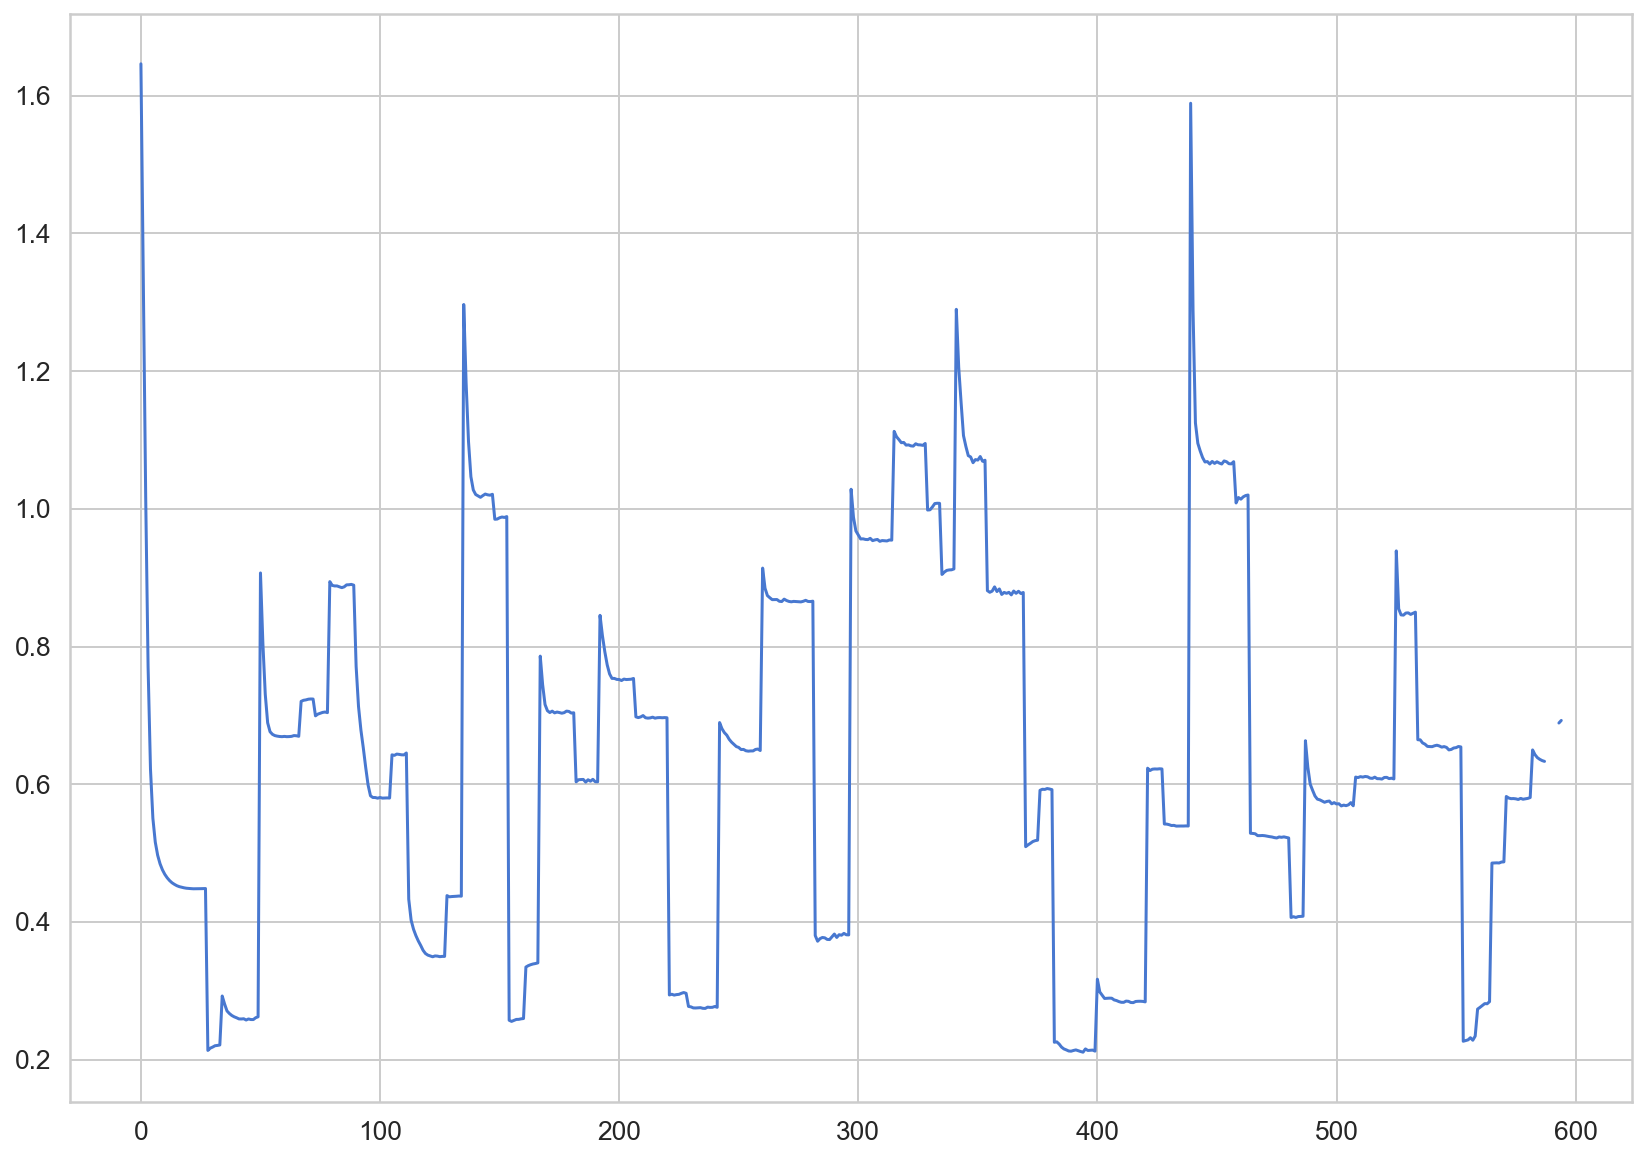

In [9]:
plt.plot(history_val_loss)

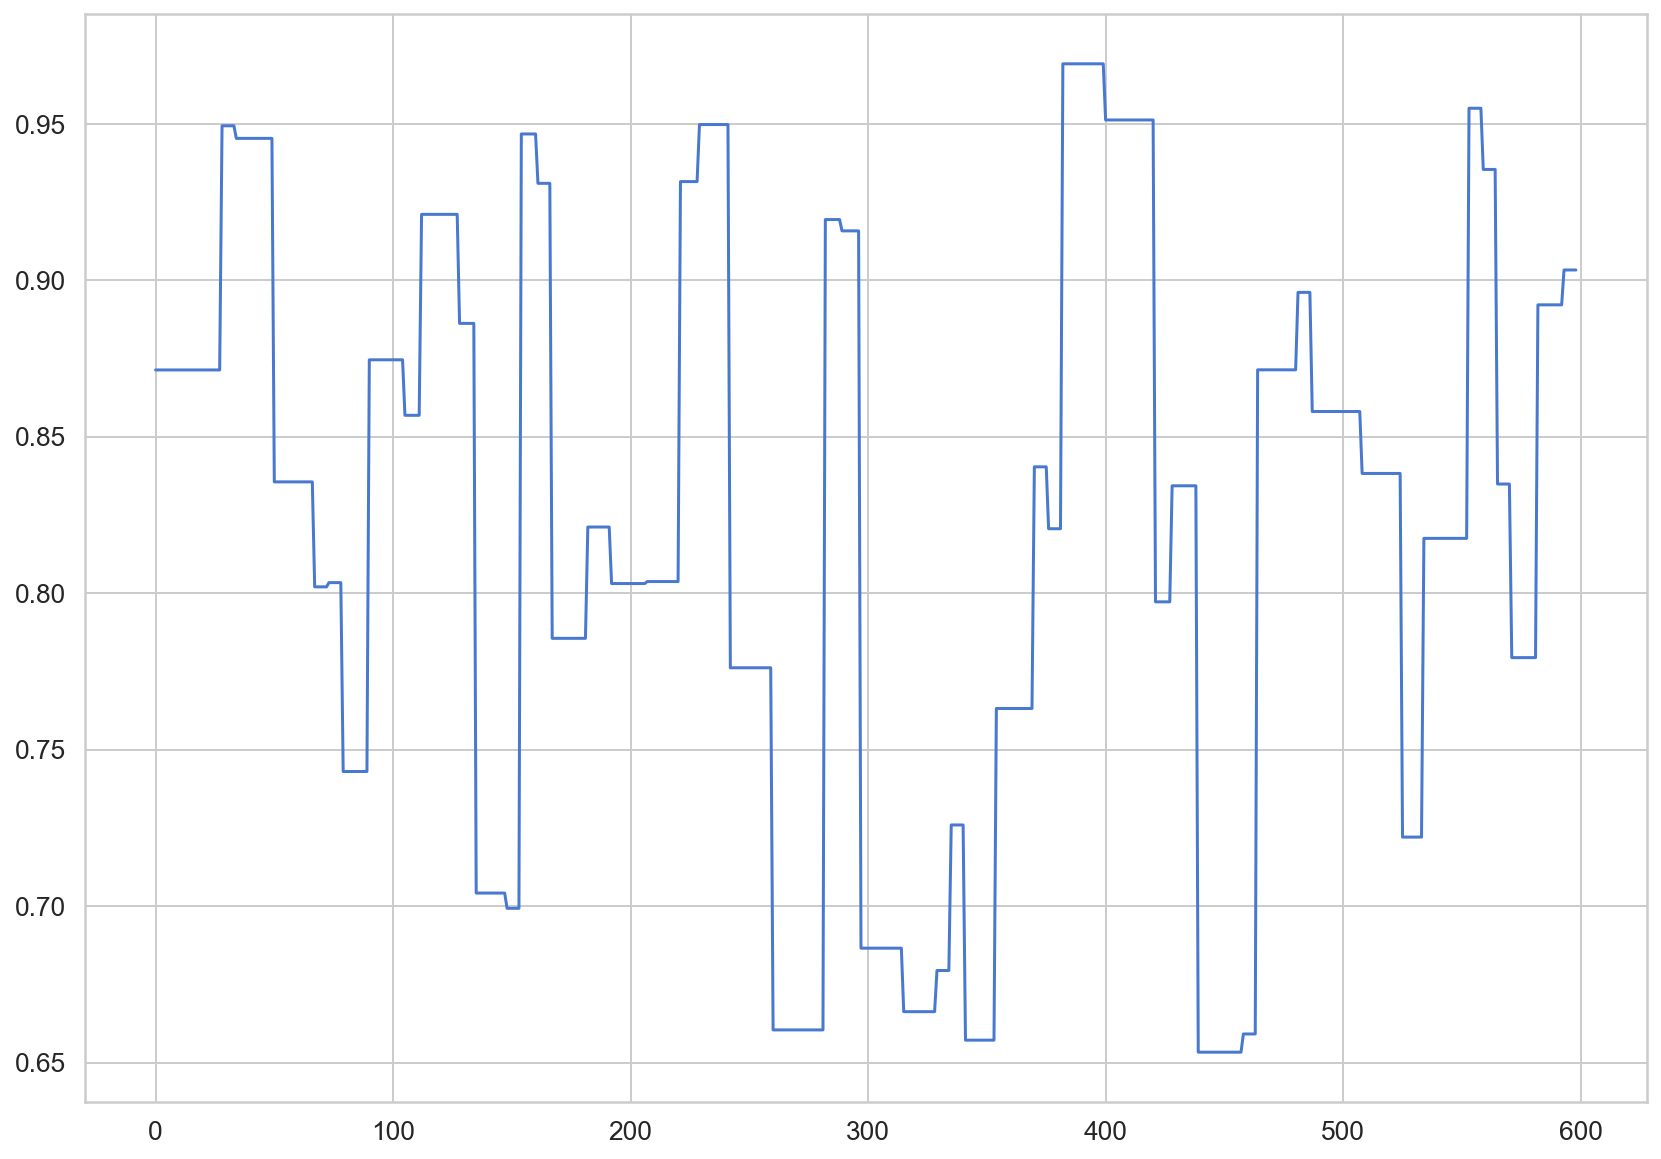

In [10]:
plt.plot(history_val_accuracy)

In [11]:
print(eval_list)

[0.8981001973152161, 0.9625668525695801, 0.947169840335846, 0.8520801067352295, 0.7919876575469971, 0.7836257219314575, 0.7753883004188538, 0.8653198480606079, 0.8595678806304932, 0.9204367995262146, 0.879687488079071, 0.6930692791938782, 0.6816901564598083, 0.9459084868431091, 0.9138381481170654, 0.769784152507782, 0.8256756663322449, 0.7894737124443054, 0.7650602459907532, 0.9113756418228149, 0.9469496011734009, 0.772357702255249, 0.6841447949409485, 0.9200000166893005, 0.9305210709571838, 0.6663157939910889, 0.6569178700447083, 0.7077294588088989, 0.7412883043289185, 0.7085714340209961, 0.7786885499954224, 0.8331053256988525, 0.8373879790306091, 0.9702127575874329, 0.9683908224105835, 0.806010901927948, 0.811977744102478, 0.6507567167282104, 0.6507567167282104, 0.8587257862091064, 0.8960526585578918, 0.8669108748435974, 0.8512658476829529, 0.7271540760993958, 0.8133515119552612, 0.9601929783821106, 0.9295010566711426, 0.8236074447631836, 0.7740113139152527, 0.8898203372955322, 0.897

In [12]:
print(sum(eval_list)/len(eval_list))

0.8267125463953205


In [13]:
from sklearn.metrics import f1_score

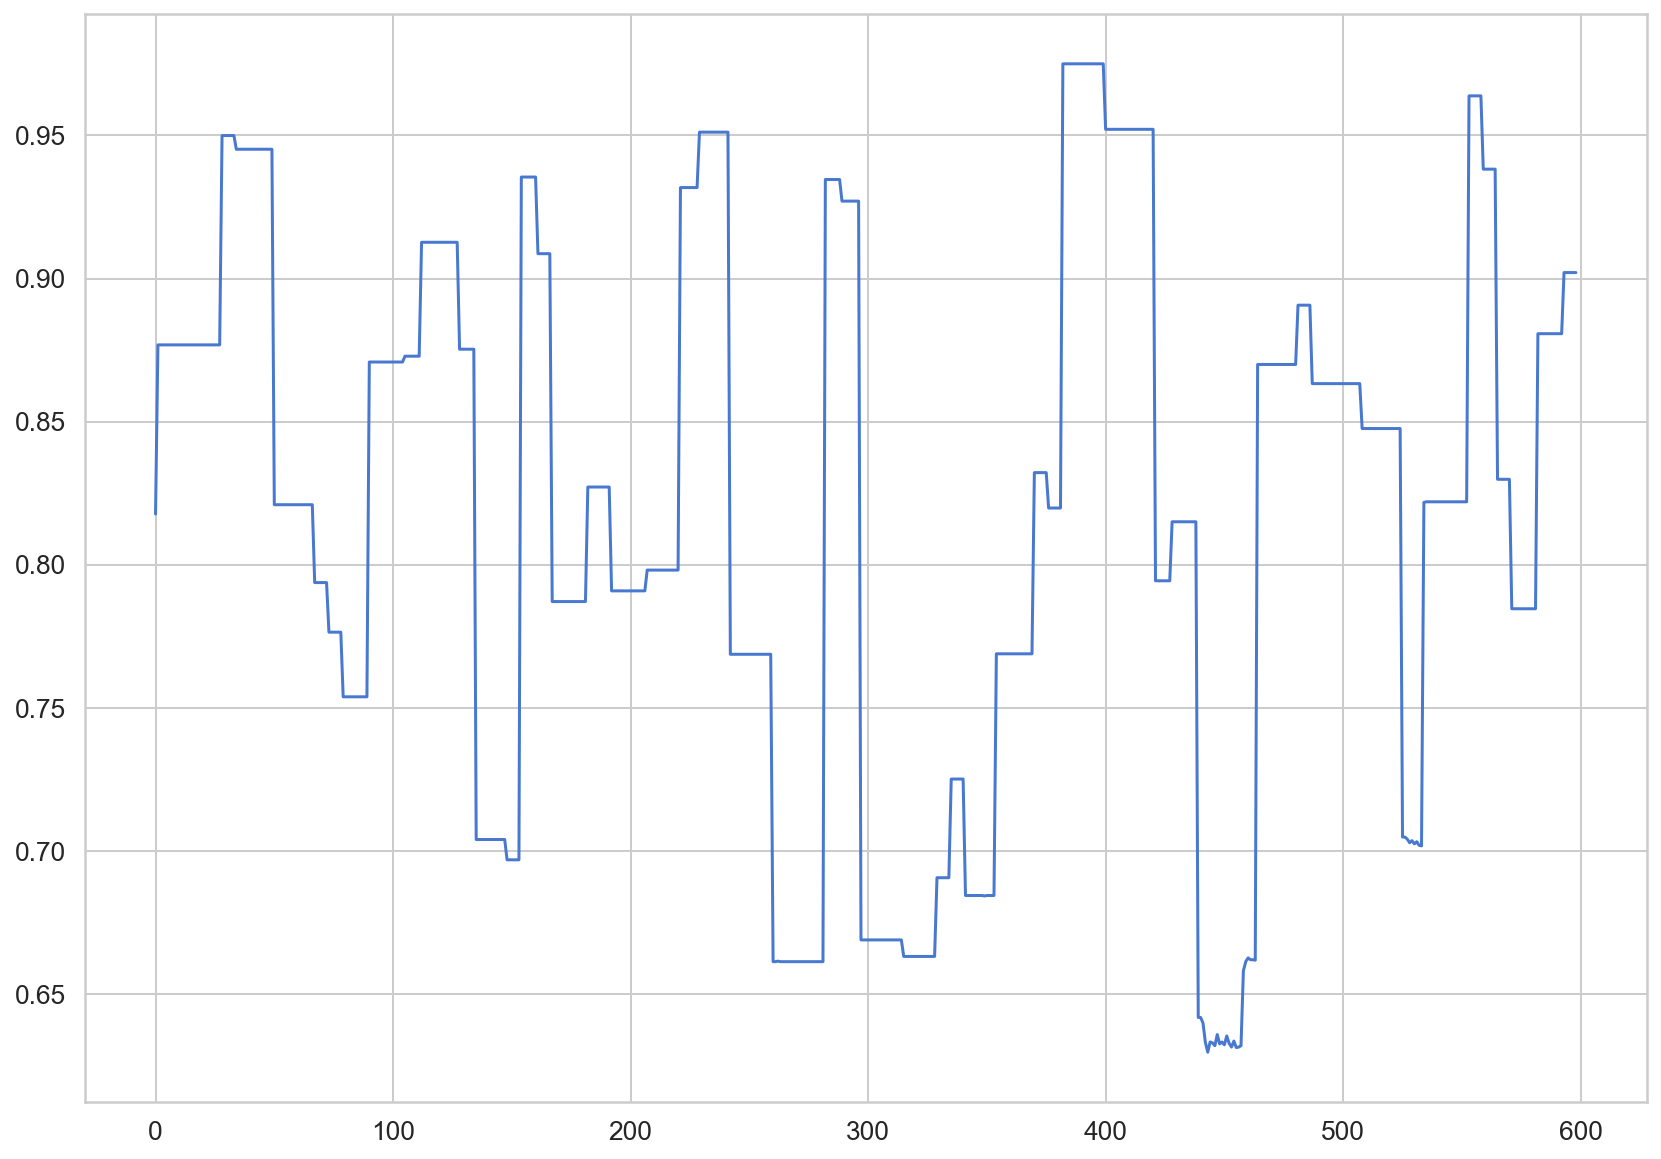

In [14]:
plt.plot(history_accuracy)